# U-Net

creiamo una rete con architettura U-Net e la addestriamo sul dataset The Oxford-IIIT Pet che contiene immagini di animali domestici con le rispettive TRIMAP che è una amppa di segmentazione suddivisa in tre categorie (sfondo, soggetto in foreground ed il brodo del sogetto detta anche categoria di incertezza).

Scarichiamo il dataset (images) con le rispettive annotazioni (annotations) dal sito ufficiale https://www.robots.ox.ac.uk/~vgg/data/pets/ ed andiamo a costruire la nostra rete U-Net.

### Annotazioni
The following annotations are available for every image in the dataset: (a) species and breed name; (b) a tight bounding box (ROI) around the head of the animal; and (c) a pixel level foreground-background segmentation (Trimap).


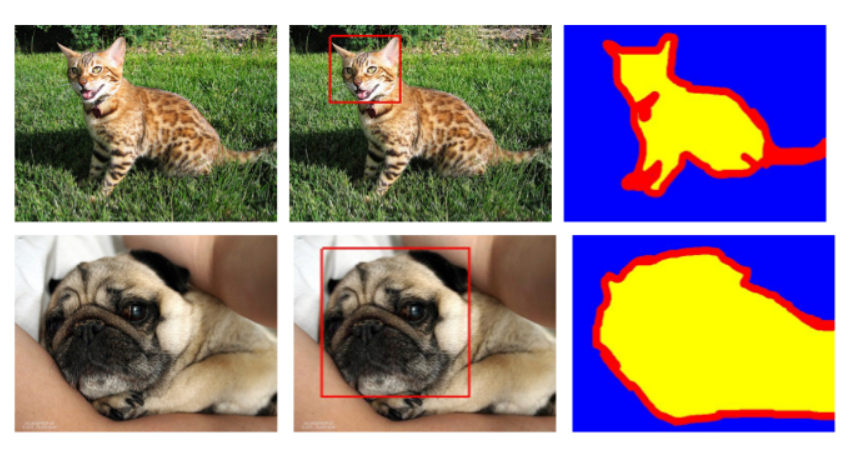

In [12]:
from IPython.display import Image, display
display(Image("Week 3-4-5_CNN\\Esercitazione U-Net\\trimap.png"))

In [13]:
# importiamo le librerie necessarie
import os
import random
from IPython.display import Image, display
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
import numpy as np
import PIL 
from PIL import ImageOps

In [14]:
# prendiamo le immagini da questa dir
input_dir = "Week 3-4-5_CNN\\Esercitazione U-Net\\images"
# immagini nere sulle quali generiamo le trimap 
target_dir = "Week 3-4-5_CNN\\Esercitazione U-Net\\annotations\\trimaps"

# ora andiamo a fare il preprocessing prima di addestrare la nostra rete
image_size=(160, 160)
#soggetto in foreground, background e zona di incertezza
num_classes=3

batch_size=32

#creiamo un lista ordinata dei path dei file di input joinati con il loro nome 
# selezionando solo i file che finiscono con .jpeg
input_img_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(".jpg")])

# stessa cosa lo facciamo con target
target_img_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith(".png") and not fname.startswith(".")])

print("numero di esempi:", len(input_img_paths))
print("numero di esempi target:", len(target_img_paths))

numero di esempi: 7390
numero di esempi target: 7390


In [15]:
# check dei path dei primi 10 input
for input_path, tearget_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", tearget_path)

Week 3-4-5_CNN\Esercitazione U-Net\images\Abyssinian_1.jpg | Week 3-4-5_CNN\Esercitazione U-Net\annotations\trimaps\Abyssinian_1.png
Week 3-4-5_CNN\Esercitazione U-Net\images\Abyssinian_10.jpg | Week 3-4-5_CNN\Esercitazione U-Net\annotations\trimaps\Abyssinian_10.png
Week 3-4-5_CNN\Esercitazione U-Net\images\Abyssinian_100.jpg | Week 3-4-5_CNN\Esercitazione U-Net\annotations\trimaps\Abyssinian_100.png
Week 3-4-5_CNN\Esercitazione U-Net\images\Abyssinian_101.jpg | Week 3-4-5_CNN\Esercitazione U-Net\annotations\trimaps\Abyssinian_101.png
Week 3-4-5_CNN\Esercitazione U-Net\images\Abyssinian_102.jpg | Week 3-4-5_CNN\Esercitazione U-Net\annotations\trimaps\Abyssinian_102.png
Week 3-4-5_CNN\Esercitazione U-Net\images\Abyssinian_103.jpg | Week 3-4-5_CNN\Esercitazione U-Net\annotations\trimaps\Abyssinian_103.png
Week 3-4-5_CNN\Esercitazione U-Net\images\Abyssinian_104.jpg | Week 3-4-5_CNN\Esercitazione U-Net\annotations\trimaps\Abyssinian_104.png
Week 3-4-5_CNN\Esercitazione U-Net\images\Abyss

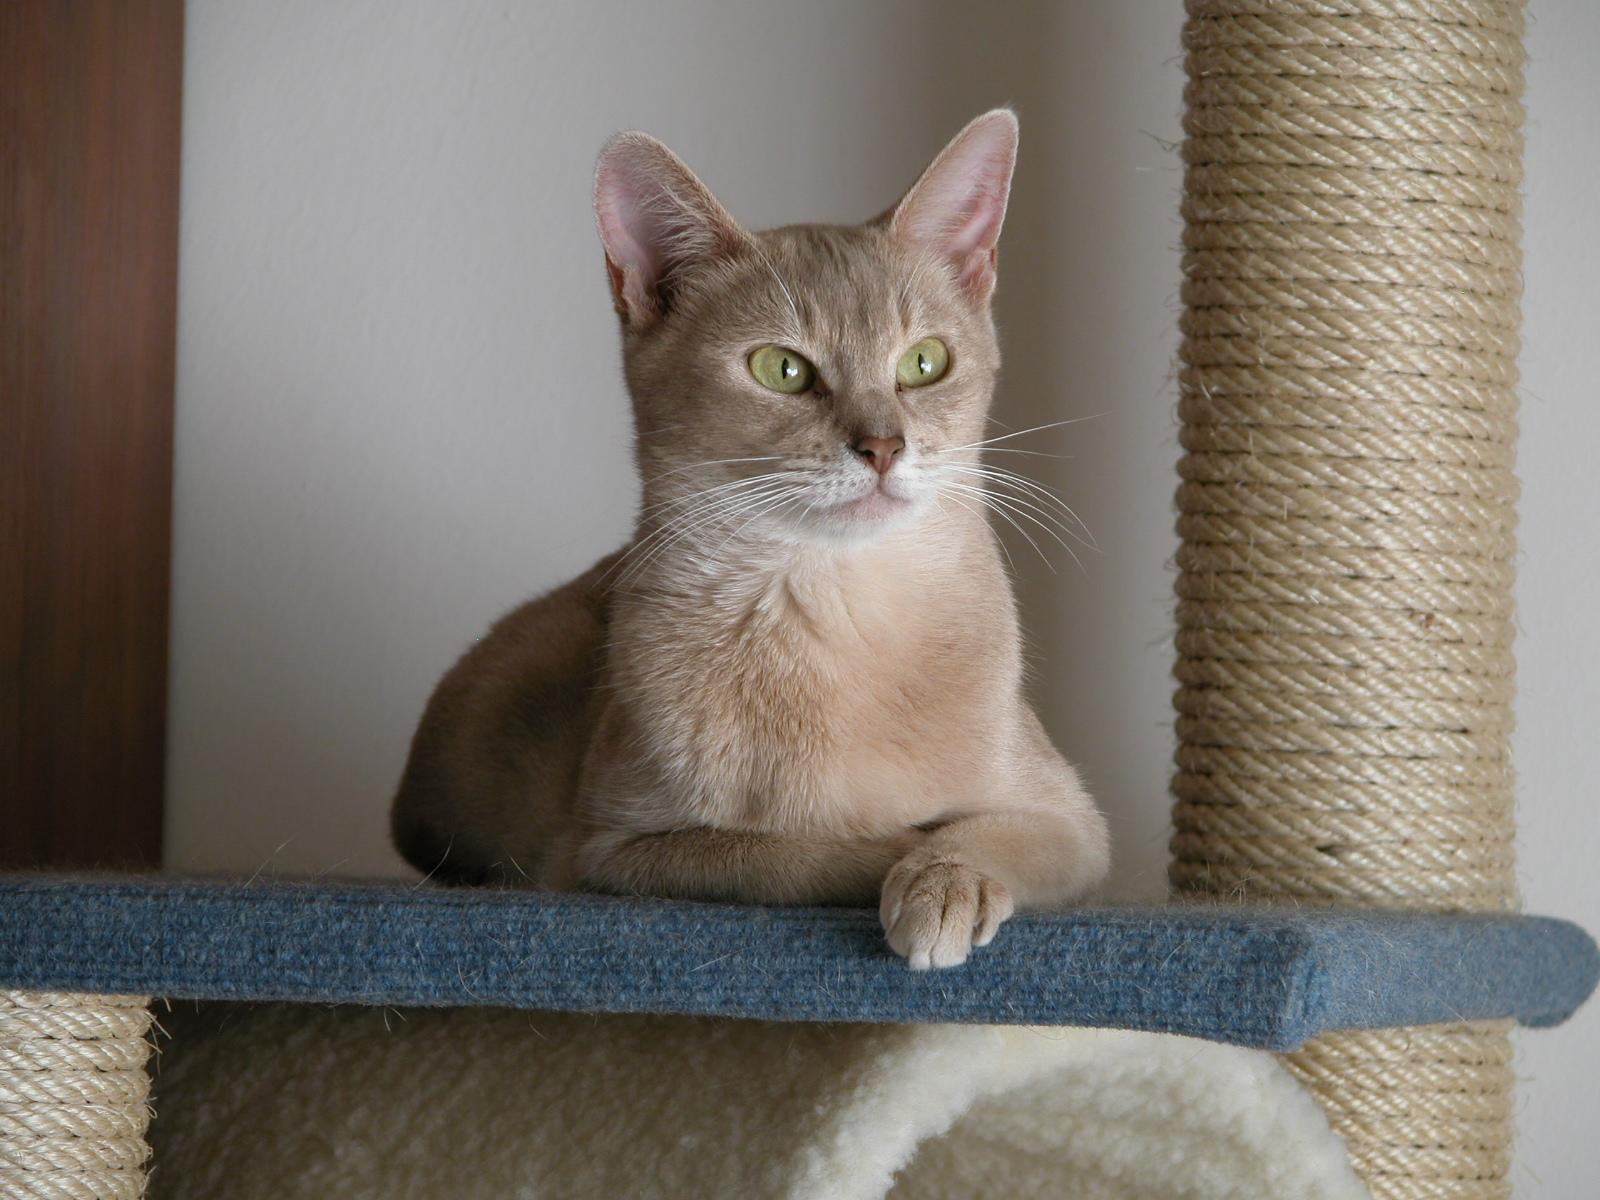

In [16]:
# stampiamo l'immagine 42
Image(input_img_paths[42])

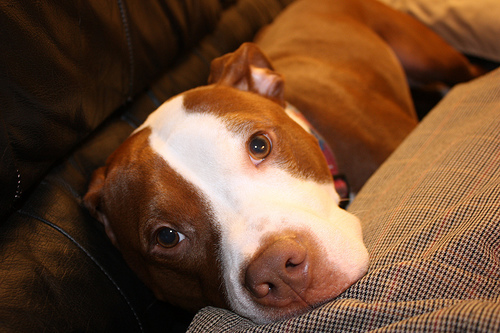

In [54]:
# Visualizzazione dell'immagine raffigurante l'area e il contorno
# del soggetto dell'immagine alla cella precedente, sfruttando il
# metodo autocontrast disponibile in PIL

import PIL.ImageOps

img = PIL.ImageOps.autocontrast(load_img(input_img_paths[942]))
display(img)

# Overidiamo la classe Sequence di Keras

Andiamo ad estendere il comportamento di tale classe.

Most python operators have an associated "magic" method (for example, a[x] is the usual way of invoking a.__getitem__(x)).

In [18]:
class OxfordPets(keras.utils.Sequence):
    '''
    Classe utile a scorrere il dataset, estende la classe Sequence
    di Keras (https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence)
    Permette l'esecuzione in parallelo del metodo __getitem__ da parte
    del processo di ottimizzazione
    '''

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        # Restituisce la tupla (input, target) corrispondente
        # al batch #idx
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Siccome le label sono in base 1, sottraiamo 1 per
            # averle con valori 0, 1 o 2
            y[j] -= 1
        return x, y

### SeparableConv2D
E' una variazione della convoluzione tradizionale, proposta per calcolarla più velocemente.
Esegue una convoluzione spaziale in profondità seguita da una convoluzione
puntuale che mescola insieme i canali di output risultanti.
![sep_conv](separable.png)
Con meno moltiplicazioni da effettuare, la complessità computazione scende, permettendo alla
rete di addestrarsi più velocemente.

In [19]:
def get_model(img_size, num_classes):
    # aggiungo i 3 canali colori alle dimensioni
    # delle immagini del dataset
    inputs = keras.Input(shape=img_size + (3,))

    # prima parte della rete, contrazione delle informazioni

    # Blocco convolutivo di ingresso
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # sfruttato per connessione residuale

    # I seguenti tre blocchi sono simili eccetto per
    # il numero dei filtri utilizzati
    for filters in [64, 128, 256]:
        # questa prima activation nella prima iterazione del ciclo non cambia niente (vedi dopo nel summary del modello)
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # connessione residuale
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x

    # Seconda parte della rete, espansione delle informazioni
    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])
        previous_block_activation = x

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model


# Svuota la memoria occupata da eventuali
# precedenti modelli TensorFlow
keras.backend.clear_session()

# Creazione modello
model = get_model(image_size, num_classes)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 160, 160, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 80, 80, 32)        │             896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 80, 80, 32)        │             128 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 80, 80, 32)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 80, 80, 32)        │               0 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d              │ (None, 80, 80, 64)        │           2,400 │ activation_1[0][0]         │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 80, 80, 64)        │             256 │ separable_conv2d[0][0]     │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 80, 80, 64)        │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_1            │ (None, 80, 80, 64)        │           4,736 │ activation_2[0][0]         │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 80, 80, 64)        │             256 │ separable_conv2d_1[0][0]   │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 40, 40, 64)        │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 40, 40, 64)        │           2,112 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 40, 40, 64)        │               0 │ max_pooling2d[0][0],       │
│                               │                           │                 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 40, 40, 64)        │               0 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 2,058,979 (7.85 MB)

 Trainable params: 2,055,203 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

In [20]:
# dopo avre visto che la rete è comprensibile andiamo a suddividere il dataset per l'addestramento e per la validazione
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:900]
train_target_img_paths = target_img_paths[:900]

val_input_img_paths = input_img_paths[900:]
val_target_img_paths = target_img_paths[900:]

# creazione  di due Sequence di dati per l'addestramento e validazione del modello
train_gen = OxfordPets(batch_size, image_size, train_input_img_paths, train_target_img_paths)

val_gen = OxfordPets(batch_size, image_size, val_input_img_paths, val_target_img_paths)

In [21]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# evento che ci permette di salvare i nostri parametri all'interno di un file solo se sono migliorativi
callbacks = [keras.callbacks.ModelCheckpoint("Week 3-4-5_CNN/Esercitazione U-Net/data/oxford_segmentation.keras", save_best_only=True)]

epochs = 15

# Addestramento
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15


C:\Users\felip\OneDrive\Desktop\MLMC\MLenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 490s 17s/step - loss: 5.6976 - val_loss: 5.0325
Epoch 2/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 270s 10s/step - loss: 0.8478 - val_loss: 2.8600
Epoch 3/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 265s 10s/step - loss: 0.7596 - val_loss: 2.2464
Epoch 4/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 273s 10s/step - loss: 0.6659 - val_loss: 2.6274
Epoch 5/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 270s 10s/step - loss: 0.6334 - val_loss: 2.9142
Epoch 6/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 264s 10s/step - loss: 0.6091 - val_loss: 3.3731
Epoch 7/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 272s 10s/step - loss: 0.5753 - val_loss: 3.0238
Epoch 8/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 260s 9s/step - loss: 0.5078 - val_loss: 3.4544
Epoch 9/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 256s 9s/step - loss: 0.4714 - val_loss: 3.3629
Epoch 10/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 261s 9s/step - loss: 0.4254 - val_loss: 4.6386
Epoch 11/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 253s 9s/step - loss: 0.4220 - val_loss: 4.1093
Epoch 12/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 240s 9s/step - loss: 0.3787 

In [23]:
# generazione delle previsioni
val_preds = model.predict(val_gen)

val_preds[1]

202/202 ━━━━━━━━━━━━━━━━━━━━ 125s 612ms/step


array([[[3.53918597e-02, 7.88287997e-01, 1.76320150e-01],
        [1.24474177e-02, 9.01775718e-01, 8.57768431e-02],
        [1.37328785e-02, 8.96391213e-01, 8.98759291e-02],
        ...,
        [3.69836949e-03, 9.76274133e-01, 2.00274978e-02],
        [6.46194676e-03, 9.68317389e-01, 2.52206493e-02],
        [6.74418546e-03, 9.83100772e-01, 1.01550212e-02]],

       [[8.25461745e-03, 9.41957593e-01, 4.97877710e-02],
        [1.82845595e-03, 9.91137624e-01, 7.03400746e-03],
        [1.91991485e-03, 9.90810990e-01, 7.26906210e-03],
        ...,
        [7.67616730e-04, 9.96684134e-01, 2.54820054e-03],
        [7.57327303e-04, 9.96401787e-01, 2.84094363e-03],
        [1.09186640e-03, 9.95998263e-01, 2.90992018e-03]],

       [[1.03200683e-02, 9.47204292e-01, 4.24756333e-02],
        [2.16370961e-03, 9.91568983e-01, 6.26733853e-03],
        [2.39587179e-03, 9.90499079e-01, 7.10507296e-03],
        ...,
        [1.30504766e-03, 9.94054377e-01, 4.64058714e-03],
        [8.85947316e-04, 9.95

In [28]:
# val_preds contiene le probabilità di appartenenza ad una delle 3 classi per ciascun pixel di ciascuna immagine del dataset di validazione
len(val_preds[5])

160

In [29]:
val_preds[5].shape

(160, 160, 3)

In [38]:
import PIL.ImageOps


def display_mask(i):
    # visualizzazione di una delle previsioni
    mask = np.argmax(val_preds[i], axis=-1) # val_preds ha 3 canali, così in mask viene creata un'immagine
                                            # senza canali in quanto argmax appiattisce l'ultima dimensione

    mask = np.expand_dims(mask, axis=-1) # ritorno della shape di mask alle dimensioni consone
                                         # di una immagine w, h, c

    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)   

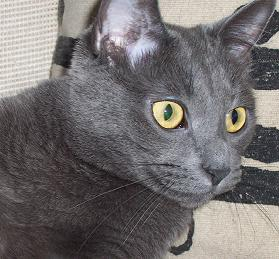

In [50]:
idx = 100
# visualizziamo l'immagine originale
display(Image(filename=val_input_img_paths[idx]))

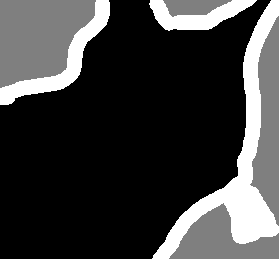

In [56]:
# visualizzazione sagoma reale
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[idx]))
display(img)

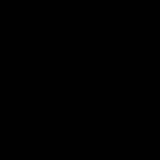

In [52]:
# visualizzazione della sagoma predetta
display_mask(idx)

# Per via del dataset incompleto (target con solo immagine nere) è impossibile addestrare il modello come si deve. Tuttavia da questa esercitazione abbiamo imparato come creare una architettura ciclando i layer con diversi numeri di filtri ed altro ancora. Lo rifaccimao su GOOGLECOLAB

# TensorFlow Datasets

TFDS provides a collection of ready-to-use datasets for use with TensorFlow, Jax, and other Machine Learning frameworks.

It handles downloading and preparing the data deterministically and constructing a `tf.data.Dataset` (or `np.array`).

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds